### Load Dataset

In [1]:
data.raw = read.csv("final_cleaned_data.csv")

In [2]:
# These values should be treated as constants
NROW = nrow(data.raw)
NCOL = ncol(data.raw)

### Filtering out seasonal component (using band filter)

In [3]:
# Oscillations to be subtracted
seasonal.annual = spectral::filter.fft(data.raw$MaxTemp, x = NULL, fc = 0.002725, BW = 0.00105, n = 2)
seasonal.biannual = spectral::filter.fft(data.raw$MaxTemp, x = NULL, fc = 0.00545, BW = 0.0002, n = 2)

# This is for recovering original data
imaginary_residuals = Im(data.raw$MaxTemp - seasonal.annual - seasonal.biannual)

# This is for further processing
data.raw.filtered = data.frame(data.raw)
data.raw.filtered$MaxTemp = Re(data.raw$MaxTemp - seasonal.annual - seasonal.biannual)

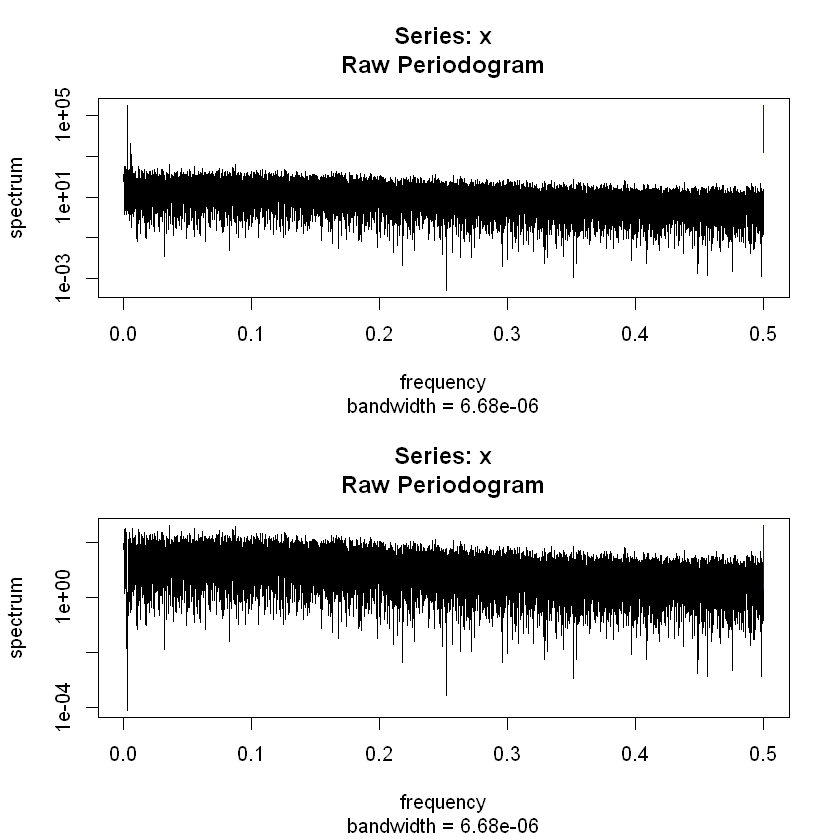

In [4]:
# Visualize periodogram (before vs after)
par(mfrow=c(2,1)) 
spectrum(data.raw$MaxTemp)
spectrum(data.raw.filtered$MaxTemp)

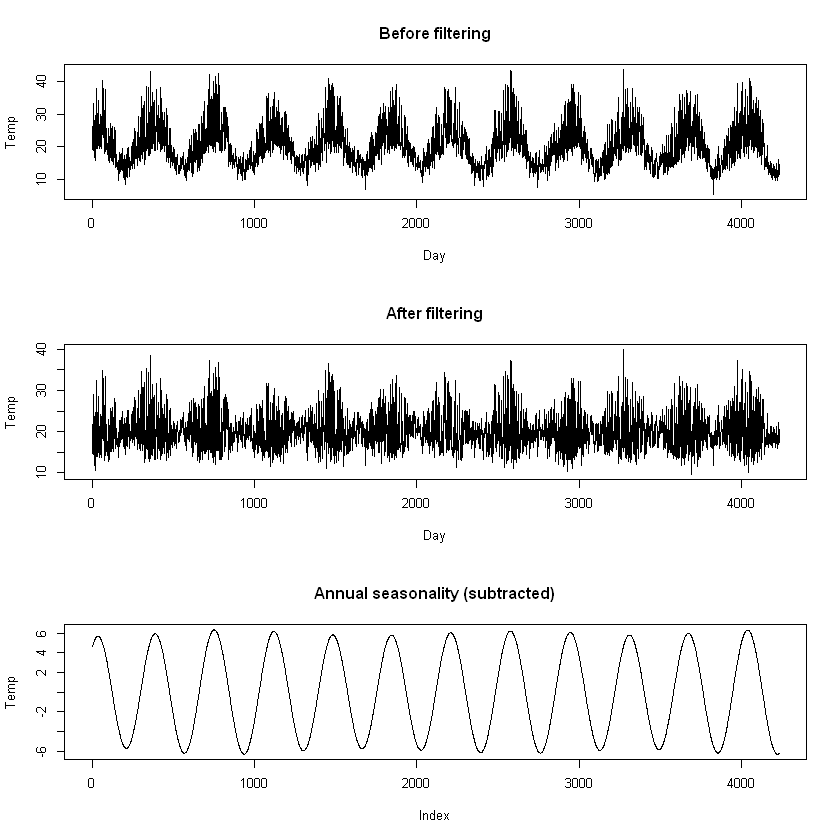

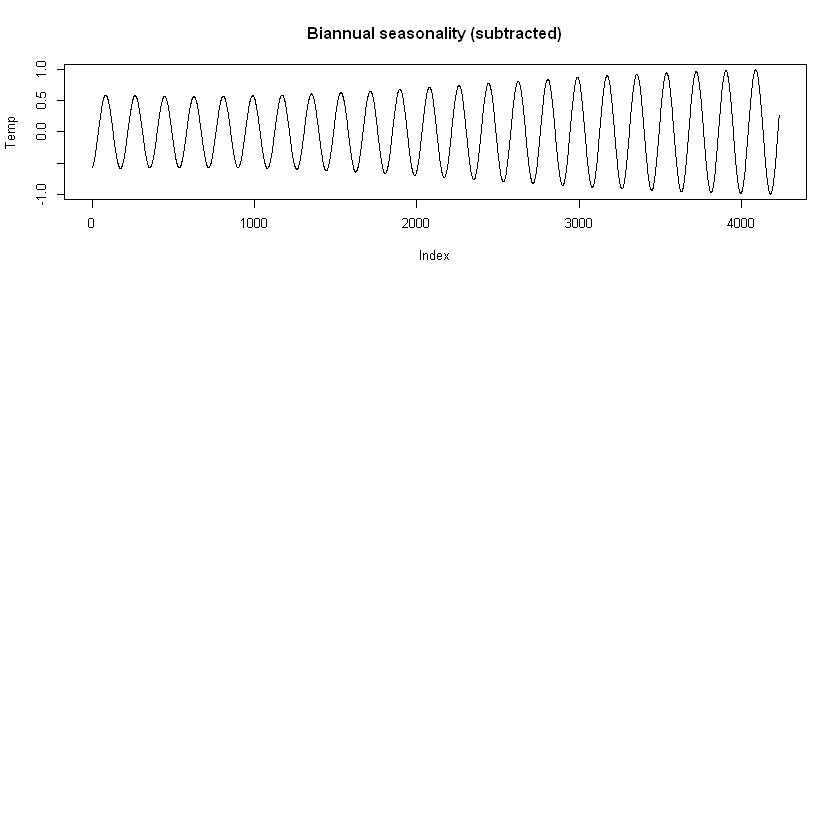

In [5]:
# Visualize time series(before vs after) and filtered components
par(mfrow=c(3,1)) 
plot(data.raw$MaxTemp[1:as.integer(NROW*0.1)], type = 'l', ylab = 'Temp', xlab = 'Day', main = 'Before filtering')
plot(data.raw.filtered$MaxTemp[1:as.integer(NROW*0.1)], type = 'l', ylab = 'Temp', xlab = 'Day', main = 'After filtering')
plot(Re(seasonal.annual[1:as.integer(NROW*0.1)]), type = 'l', ylab = 'Temp', main = 'Annual seasonality (subtracted)')
plot(Re(seasonal.biannual[1:as.integer(NROW*0.1)]), type = 'l', ylab = 'Temp', main = 'Biannual seasonality (subtracted)')

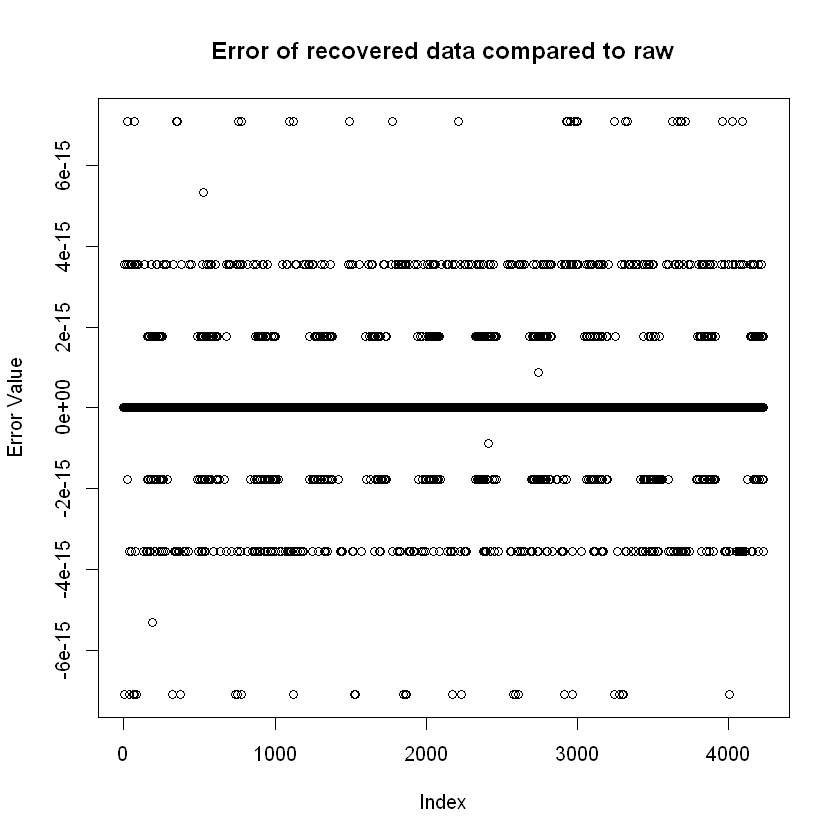

In [6]:
# Simulate procedure of recovering raw data from subtracted components
recovered = complex(imaginary = imaginary_residuals, real = data.raw.filtered$MaxTemp) + seasonal.annual + seasonal.biannual
plot((Re(recovered) - data.raw$MaxTemp)[1:as.integer(NROW*0.1)], ylab = 'Error Value', main = 'Error of recovered data compared to raw')

### Normalize data to obtain data with constant variance (over time)

In [7]:
data.raw.filtered.normalized = data.frame(data.raw.filtered)

# Find average and variance of each day of the year
grouped.daily.var = aggregate(MaxTemp ~ Month*Day, data.raw.filtered.normalized, FUN = var)
grouped.daily.var = grouped.daily.var[order(grouped.daily.var$Month, grouped.daily.var$Day), ]
grouped.daily.avg = aggregate(MaxTemp ~ Month*Day, data.raw.filtered.normalized, FUN = mean)
grouped.daily.avg = grouped.daily.avg[order(grouped.daily.avg$Month, grouped.daily.avg$Day), ]

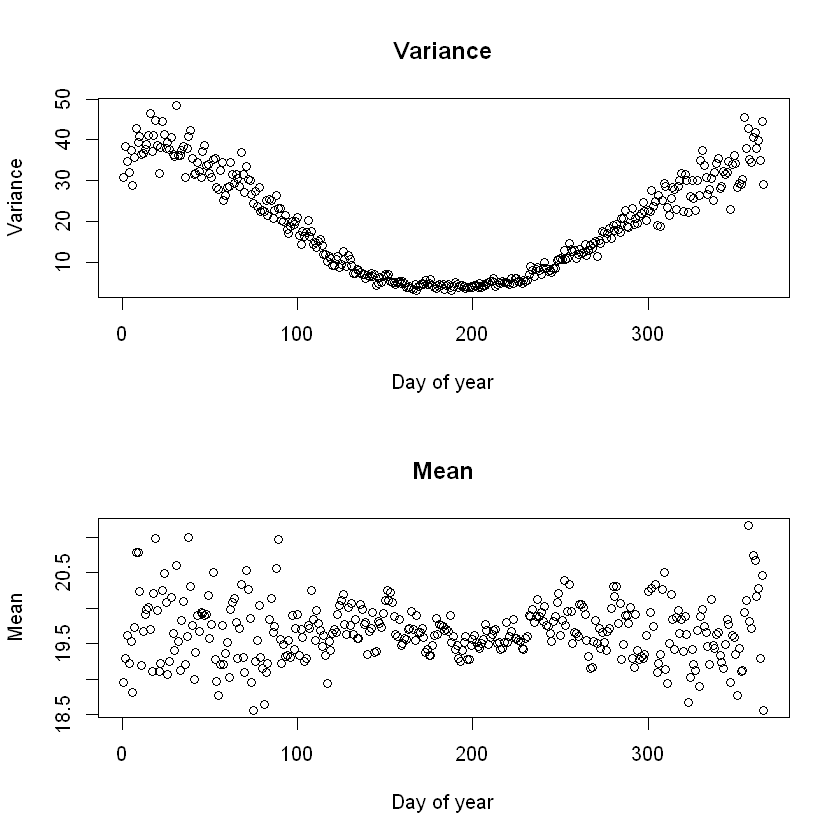

In [8]:
# Visualize grouped variance and average
par(mfrow=c(2,1)) 
plot(grouped.daily.var$MaxTemp, ylab = 'Variance', xlab = 'Day of year', main = 'Variance')
plot(grouped.daily.avg$MaxTemp, ylab = 'Mean', xlab = 'Day of year', main = 'Mean')

In [9]:
normalize = function(x, grouped_daily_var, grouped_daily_avg){
    for (row in c(1: nrow(x))){
        month = x[row, 2]
        day = x[row, 3]
        
        variance = grouped_daily_var[ which(grouped_daily_var$Month == month & grouped_daily_var$Day == day), ]$MaxTemp
        mean = grouped_daily_avg[ which(grouped_daily_avg$Month == month & grouped_daily_avg$Day == day), ]$MaxTemp
        
        x[row, 4] = (x[row, 4] - mean )/ sqrt(variance)
    }
    
    return(x)
}

In [10]:
data.raw.filtered.normalized = normalize(data.raw.filtered.normalized, grouped.daily.var, grouped.daily.avg)

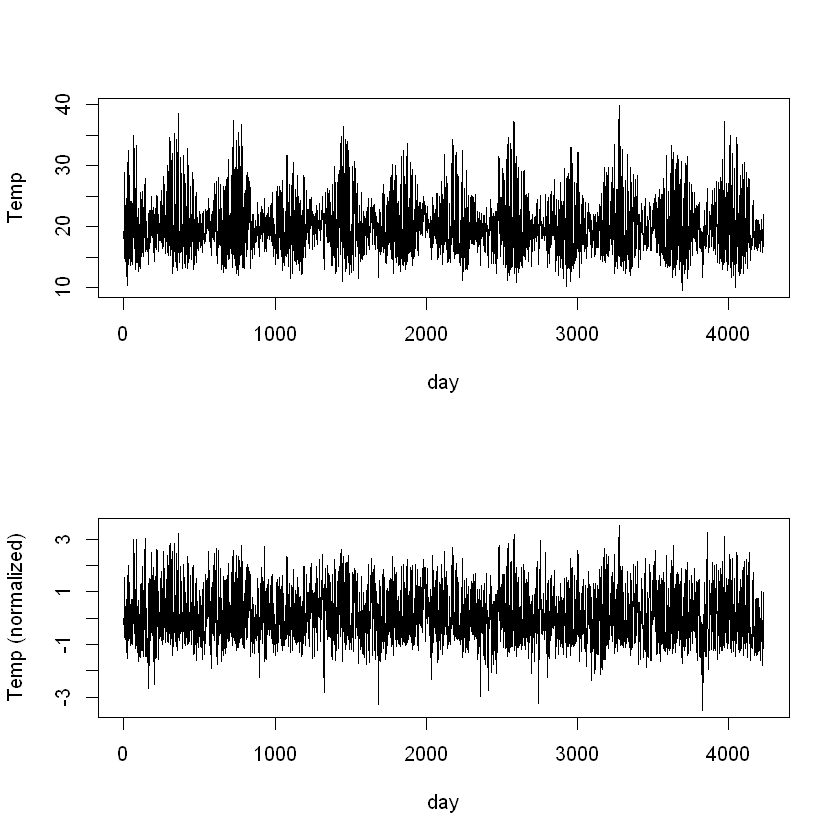

In [11]:
# Visualize normalized time series (before and after)
par(mfrow=c(2,1)) 
plot(data.raw.filtered$MaxTemp[1:as.integer(NROW*0.1)], ylab = 'Temp', xlab = 'day', type = 'l')
plot(data.raw.filtered.normalized$MaxTemp[1:as.integer(NROW*0.1)], ylab = 'Temp (normalized)', xlab ='day', type = 'l')

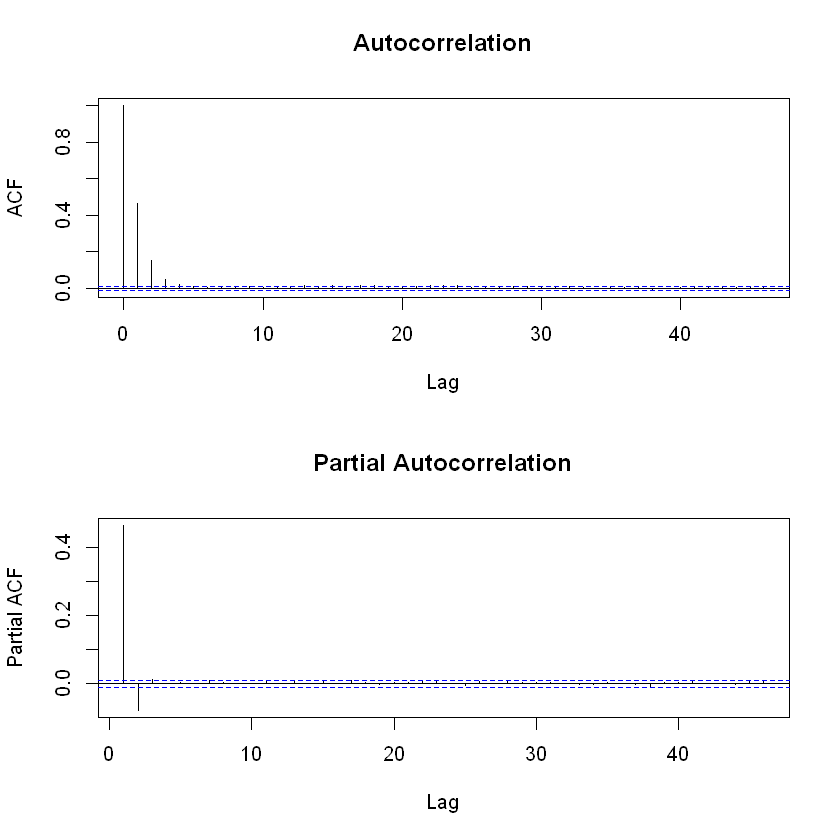

In [21]:
# Visualize acf and pacf of normalized time series
par(mfrow=c(2,1))
acf(data.raw.filtered.normalized$MaxTemp, main = 'Autocorrelation')
pacf(data.raw.filtered.normalized$MaxTemp, main = 'Partial Autocorrelation')

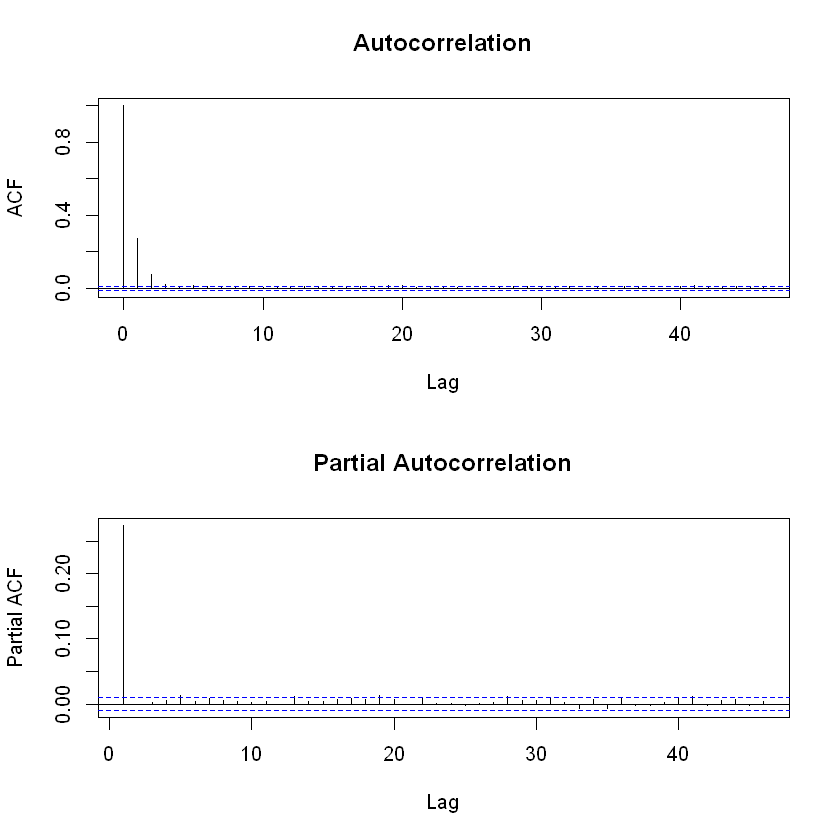

In [20]:
# Visualize acf and pacf of normalized time series
par(mfrow=c(2,1))
acf((data.raw.filtered.normalized$MaxTemp)^2, main = 'Autocorrelation')
pacf((data.raw.filtered.normalized$MaxTemp)^2, main = 'Partial Autocorrelation')

### Stationarity Tests

Warning message:
"package 'LSTS' was built under R version 3.4.4"

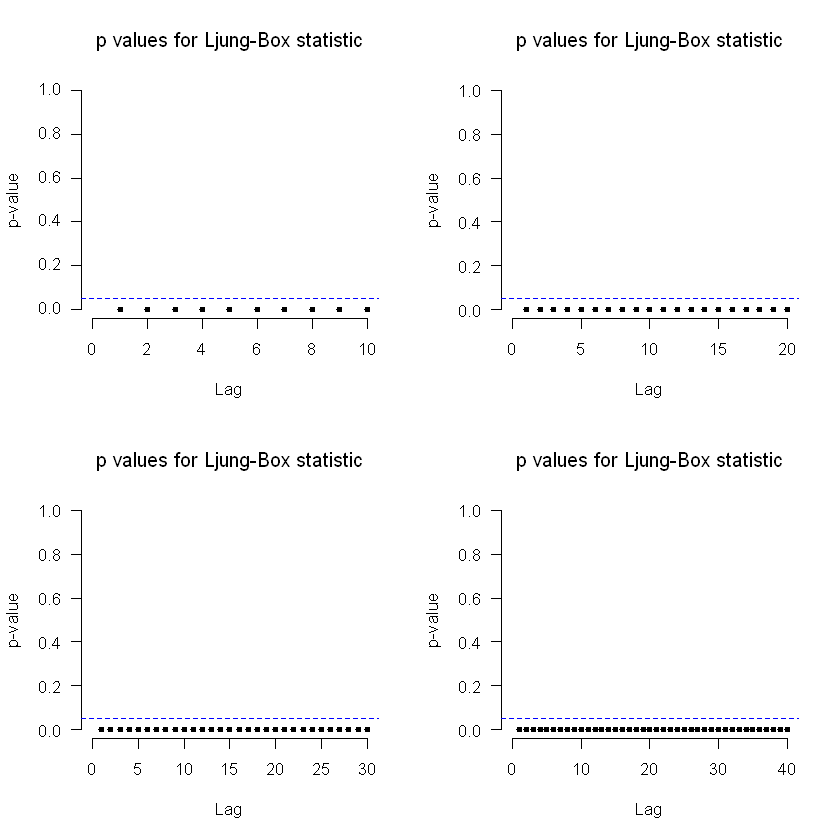

In [13]:
library(LSTS)
# Use ljung box test to test for stationarity of normalized time series
par(mfrow=c(2,2))
Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 10)
Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 20)
Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 30)
Box.Ljung.Test(data.raw.filtered.normalized$MaxTemp, lag = 40)

In [14]:
# Augmented dickey fuller test to test for stationarity
library(aTSA)
adf.test(data.raw.filtered.normalized$MaxTemp, output = TRUE)


Attaching package: 'aTSA'

The following object is masked from 'package:LSTS':

    ts.diag

The following object is masked from 'package:graphics':

    identify



Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
      lag    ADF p.value
 [1,]   0 -124.4    0.01
 [2,]   1 -115.1    0.01
 [3,]   2  -99.1    0.01
 [4,]   3  -89.3    0.01
 [5,]   4  -81.5    0.01
 [6,]   5  -75.7    0.01
 [7,]   6  -70.3    0.01
 [8,]   7  -66.3    0.01
 [9,]   8  -63.1    0.01
[10,]   9  -60.2    0.01
[11,]  10  -57.2    0.01
[12,]  11  -55.0    0.01
[13,]  12  -52.7    0.01
[14,]  13  -50.9    0.01
[15,]  14  -48.9    0.01
[16,]  15  -47.6    0.01
Type 2: with drift no trend 
      lag    ADF p.value
 [1,]   0 -124.4    0.01
 [2,]   1 -115.1    0.01
 [3,]   2  -99.1    0.01
 [4,]   3  -89.3    0.01
 [5,]   4  -81.5    0.01
 [6,]   5  -75.7    0.01
 [7,]   6  -70.3    0.01
 [8,]   7  -66.3    0.01
 [9,]   8  -63.1    0.01
[10,]   9  -60.2    0.01
[11,]  10  -57.2    0.01
[12,]  11  -55.0    0.01
[13,]  12  -52.7    0.01
[14,]  13  -50.9    0.01
[15,]  14  -48.9    0.01
[16,]  15  -47.6    0.01
Type 3: with drift and trend 
      l

### ARMA

In [17]:
ts = ts(data.raw.filtered.normalized$MaxTemp, frequency = 1)

In [19]:
library(forecast)

ar2 <- Arima(ts, order = c(2, 0, 0))
ar3 <- Arima(ts, order = c(3, 0, 0)) 
ar1ma1 <- Arima(ts, order = c(1, 0, 1))
ar2ma1 <- Arima(ts, order = c(2, 0, 1))
ar3ma1 <- Arima(ts, order = c(3, 0, 1))


Attaching package: 'forecast'

The following object is masked from 'package:aTSA':

    forecast



### Check residuals

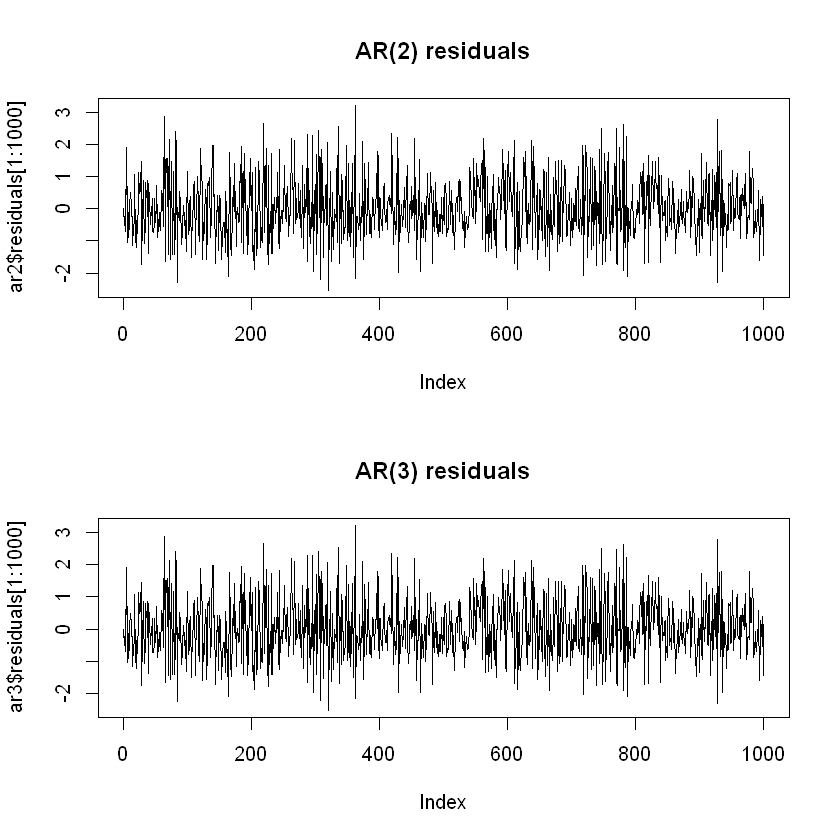

In [115]:
par(mfrow=c(2,1))
plot(ar2$residuals[1:1000], type = 'l', main = 'AR(2) residuals')
plot(ar3$residuals[1:1000], type = 'l', main = 'AR(3) residuals')

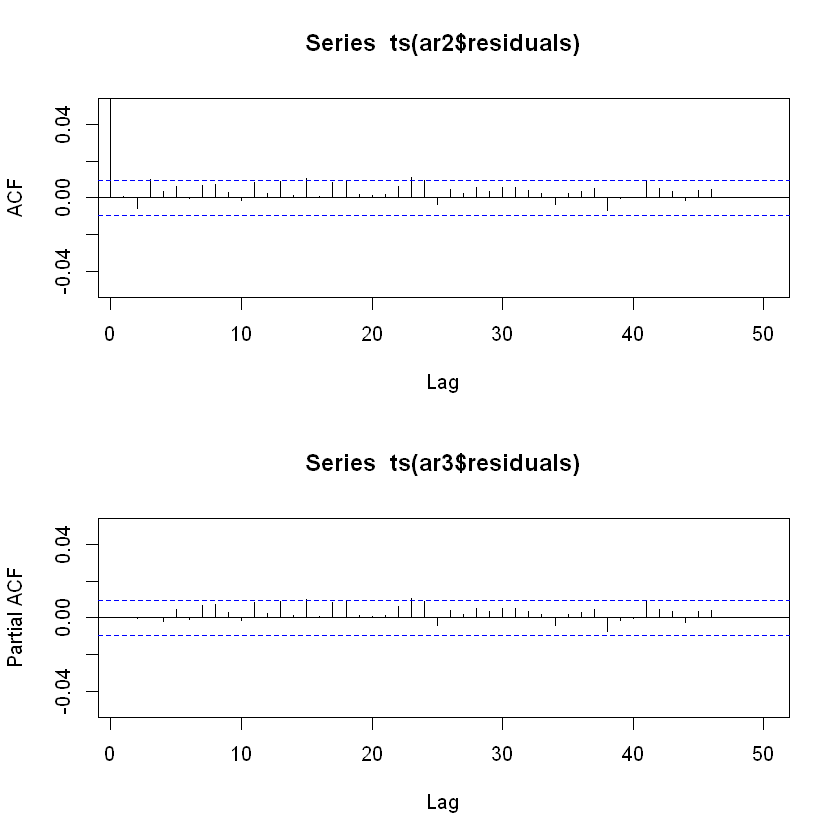

In [116]:
par(mfrow=c(2,1))
acf(ts(ar2$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05))
pacf(ts(ar3$residuals), xlim=c(1,50), ylim = c(-0.05, 0.05))

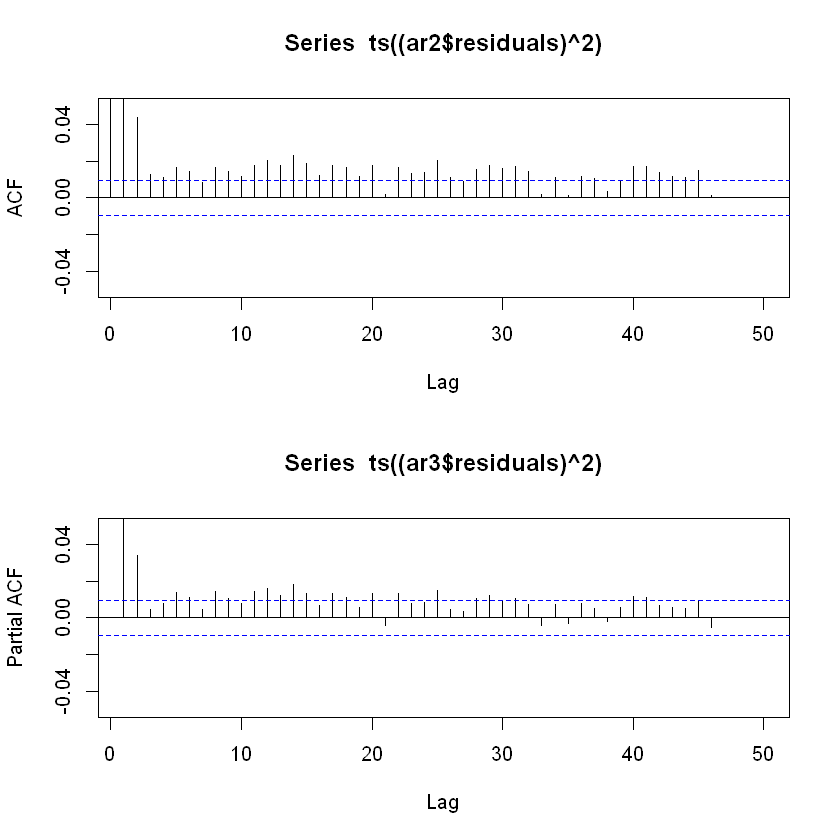

In [133]:
par(mfrow=c(2,1))
acf(ts((ar2$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05))
pacf(ts((ar3$residuals)^2), xlim=c(1,50), ylim = c(-0.05, 0.05))

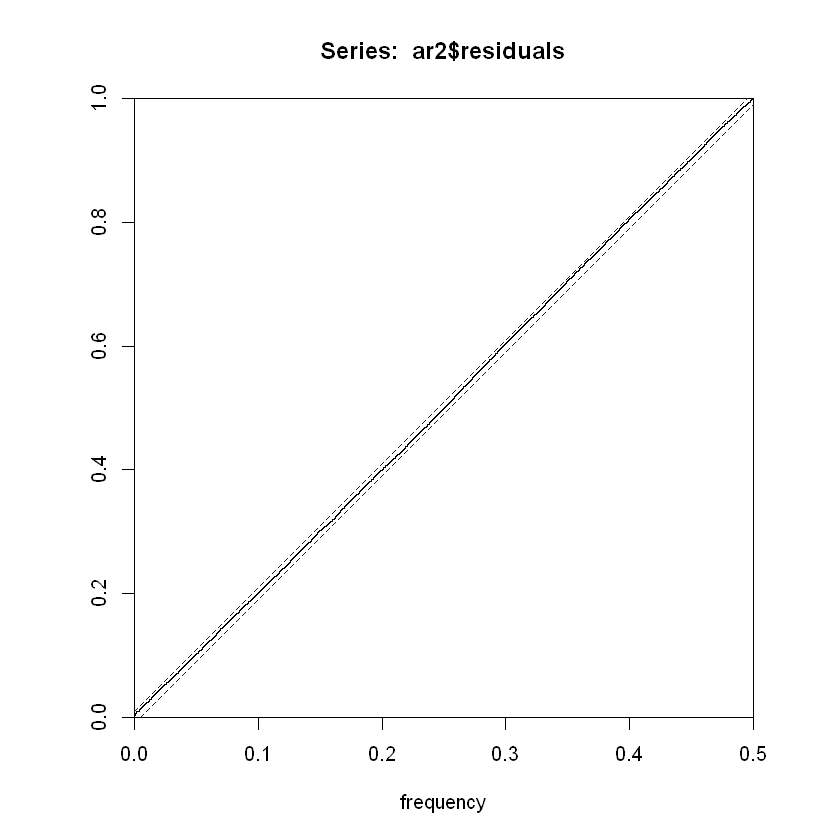

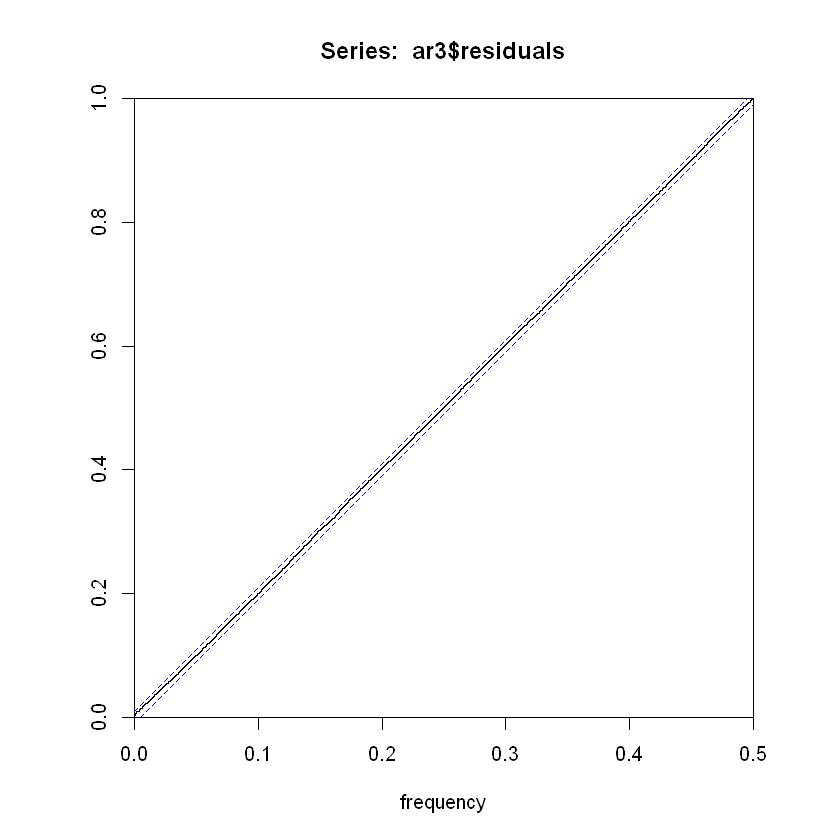

In [132]:
cpgram(ar2$residuals)
cpgram(ar3$residuals)

In [128]:
summary(ar2)
summary(ar3)

Series: ts 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
         ar1      ar2    mean
      0.5002  -0.0773  0.0000
s.e.  0.0048   0.0048  0.0074

sigma^2 estimated as 0.773:  log likelihood=-54626.27
AIC=109260.5   AICc=109260.5   BIC=109295.2

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -1.028133e-05 0.8791846 0.7056986 99.18318 234.0203 0.9049466
                    ACF1
Training set 0.000999539
Series: ts 
ARIMA(3,0,0) with non-zero mean 

Coefficients:
         ar1      ar2     ar3    mean
      0.5012  -0.0837  0.0128  0.0000
s.e.  0.0049   0.0054  0.0049  0.0075

sigma^2 estimated as 0.7729:  log likelihood=-54622.81
AIC=109255.6   AICc=109255.6   BIC=109298.9

Training set error measures:
                        ME      RMSE       MAE     MPE     MAPE    MASE
Training set -1.020934e-05 0.8791127 0.7058104 99.7468 234.3031 0.90509
                     ACF1
Training set 3.147659e-06


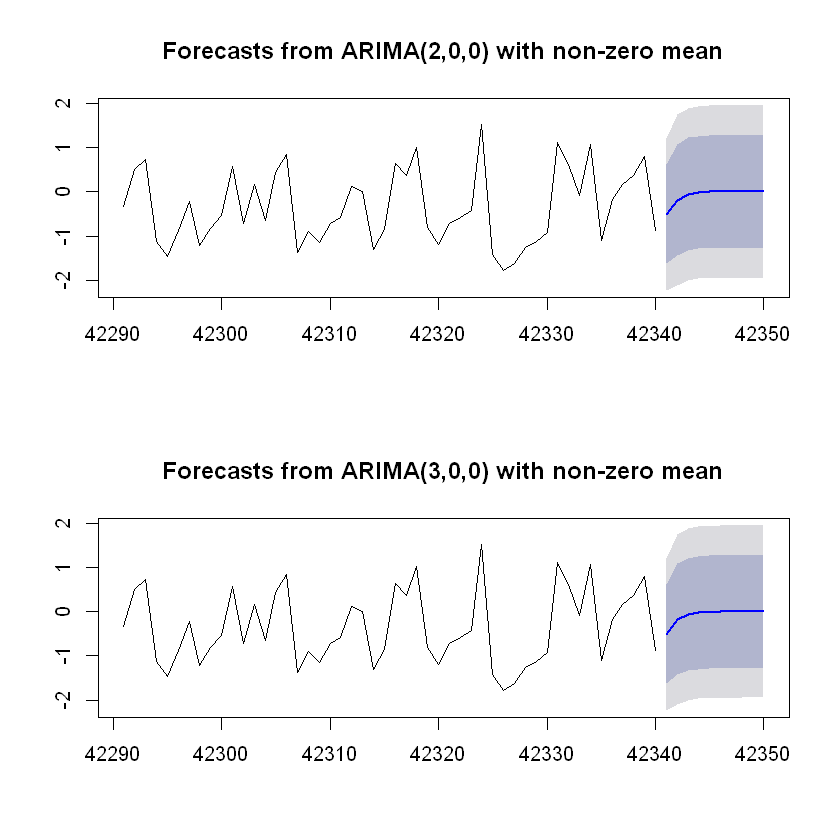

In [124]:
par(mfrow=c(2,1))
ar2_forecast <- forecast(ar2, h=10)
plot(ar2_forecast, include = 50)

ar3_forecast <- forecast(ar3, h=10)
plot(ar3_forecast, include = 50)

### ARMA-GARCH

In [23]:
# install.packages("rugarch", repos = "http://cran.us.r-project.org") 
library(rugarch)
require(rugarch)

In [46]:
model = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 
    1)), mean.model = list(armaOrder = c(2, 0), include.mean = TRUE), distribution.model = "norm")
model

model1 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 
    0)), mean.model = list(armaOrder = c(2, 0), include.mean = TRUE), distribution.model = "norm")
model1

model2 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 
    0)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model2

model3 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(0, 
    1)), mean.model = list(armaOrder = c(2, 0), include.mean = TRUE), distribution.model = "norm")
model3

model4 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(2, 
    0)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model4

model5 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(3, 
    0)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model5

model6 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(2, 
    1)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model6

model7 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(2, 
    2)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model7

model8 = ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(3, 
    2)), mean.model = list(armaOrder = c(3, 0), include.mean = TRUE), distribution.model = "norm")
model8


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(2,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(2,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(0,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(2,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(2,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(3,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(2,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(2,2)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(3,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 


In [47]:
model_fit <- ugarchfit(spec = model, data = ts, solver = "hybrid")
convergence(model_fit)
model_fit_1 = ugarchfit(spec = model1, data = ts, solver = "hybrid")
convergence(model_fit_1)
model_fit_2 = ugarchfit(spec = model2, data = ts, solver = "hybrid")
convergence(model_fit_2)
model_fit_3 = ugarchfit(spec = model3, data = ts, solver = "hybrid")
convergence(model_fit_3)
model_fit_4 = ugarchfit(spec = model4, data = ts, solver = "hybrid")
convergence(model_fit_4)
model_fit_5 = ugarchfit(spec = model5, data = ts, solver = "hybrid")
convergence(model_fit_5)
model_fit_6 = ugarchfit(spec = model6, data = ts, solver = "hybrid")
convergence(model_fit_6)
model_fit_7 = ugarchfit(spec = model7, data = ts, solver = "hybrid")
convergence(model_fit_7)

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

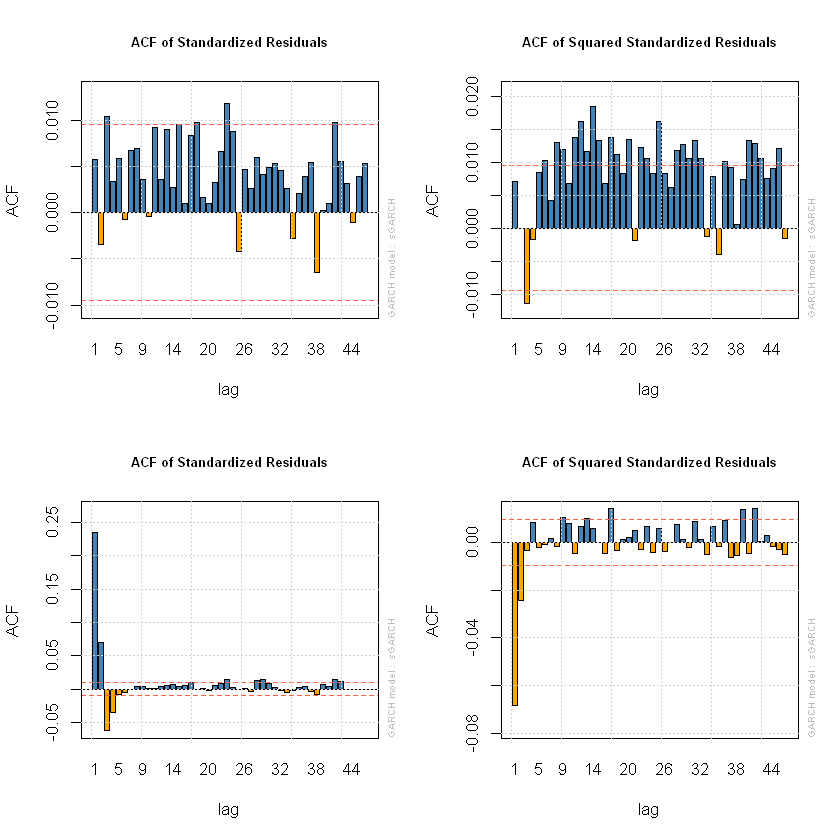

In [30]:
par(mfrow=c(2,2))
plot(model_fit, which = 10)
plot(model_fit, which = 11)
plot(model_fit_1, which = 10)
plot(model_fit_1, which = 11)

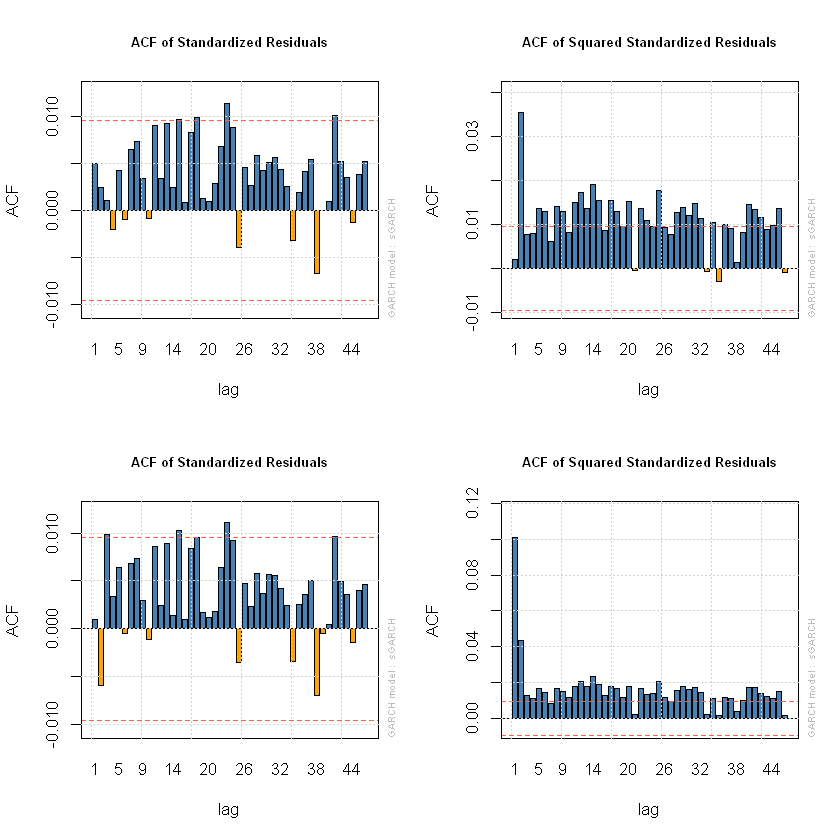

In [33]:
par(mfrow=c(2,2))
plot(model_fit_2, which = 10)
plot(model_fit_2, which = 11)
plot(model_fit_3, which = 10)
plot(model_fit_3, which = 11)

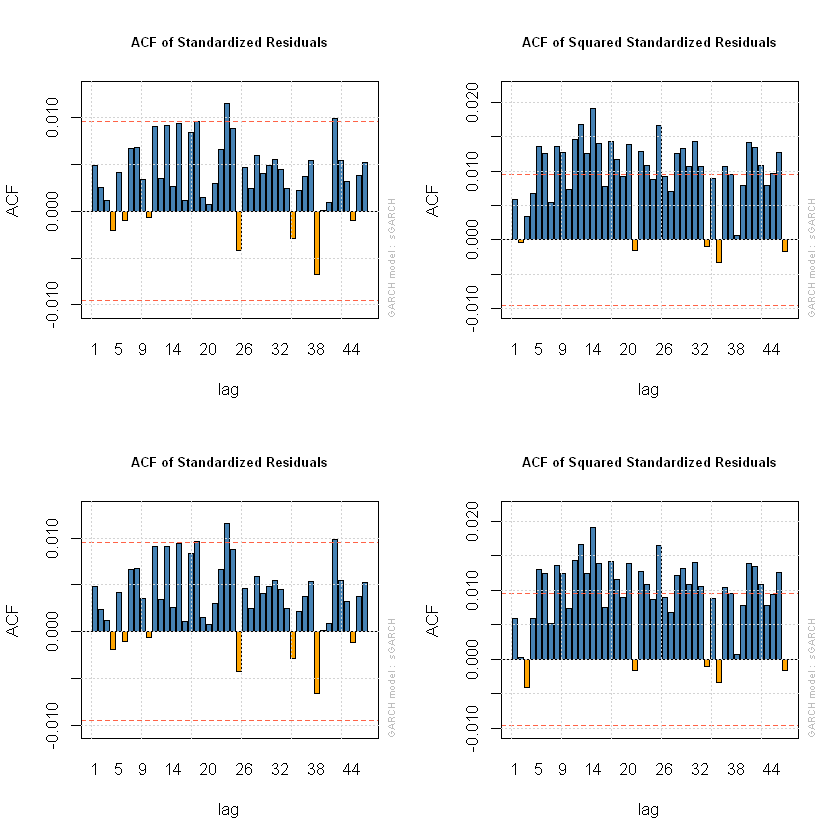

In [40]:
par(mfrow=c(2,2))
plot(model_fit_4, which = 10)
plot(model_fit_4, which = 11)
plot(model_fit_5, which = 10)
plot(model_fit_5, which = 11)

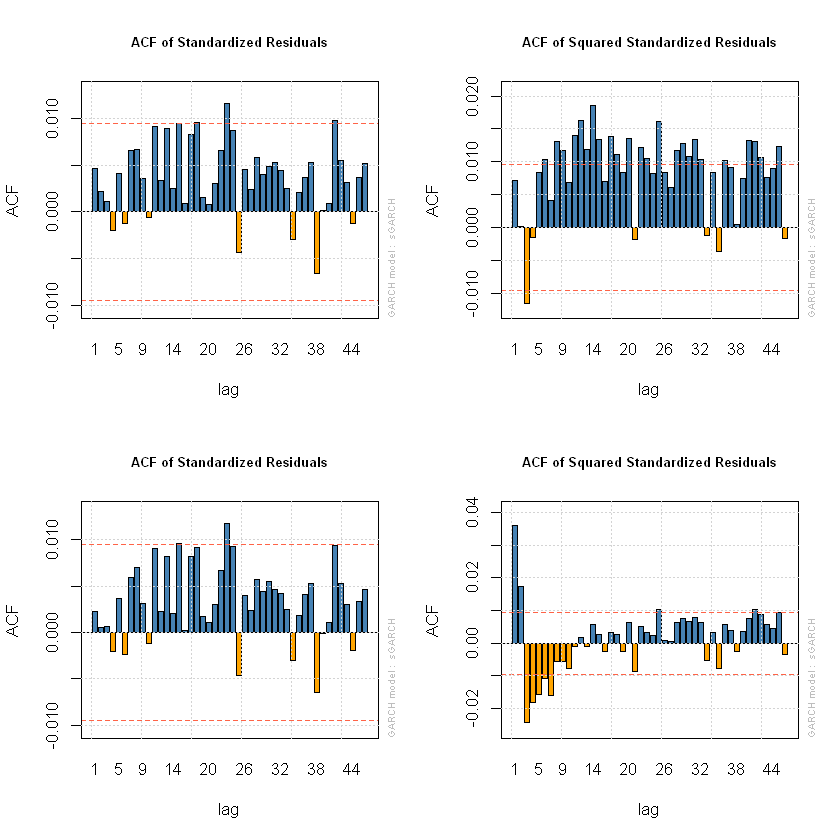

In [48]:
par(mfrow=c(2,2))
plot(model_fit_6, which = 10)
plot(model_fit_6, which = 11)
plot(model_fit_7, which = 10)
plot(model_fit_7, which = 11)

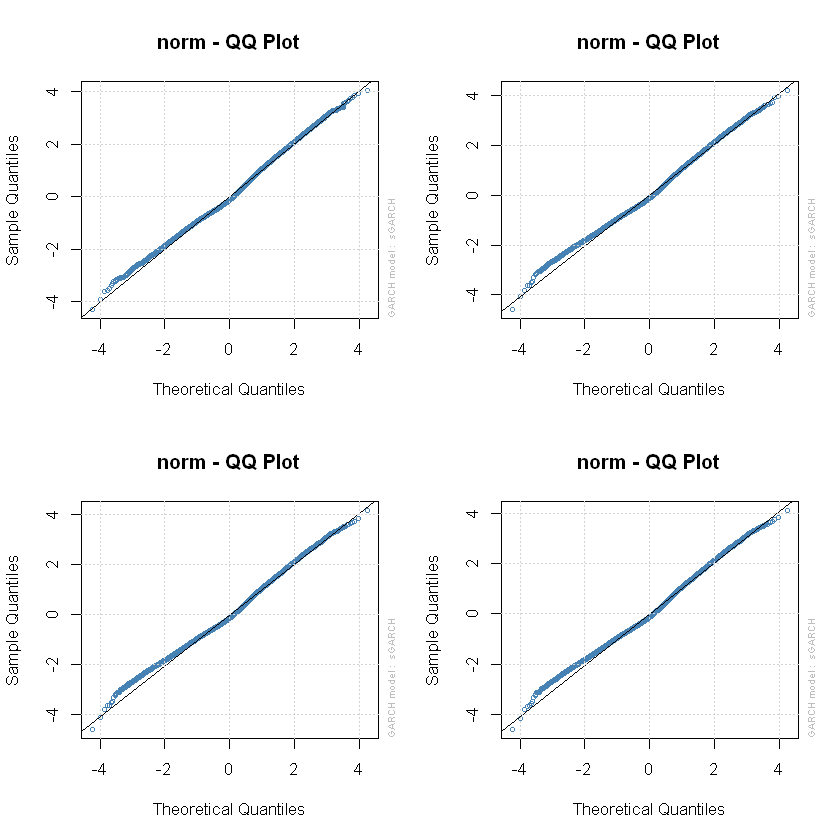

In [45]:
par(mfrow=c(2,2))
plot(model_fit_3, which = 9)
plot(model_fit_4, which = 9)
plot(model_fit_5, which = 9)
plot(model_fit_6, which = 9)